### Module Imports and Functions

In [1]:
# Importing modules to access and visualise data
import xarray as xr # used for netcdf and h5 files, climate data
import h5py
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfea
from pyproj import Transformer
import pyproj
import datetime
from scipy.interpolate import griddata
from scipy.stats import binned_statistic_2d
import os, sys
from matplotlib.colors import LinearSegmentedColormap


In [2]:
def WGS84toEASE2N(lon, lat):
    proj_EASE2N = pyproj.Proj("+proj=laea +lon_0=0 +lat_0=90 +x_0=0 +y_0=0 +ellps=WGS84 +towgs84=0,0,0,0,0,0,0 +units=m +no_defs")
    proj_WGS84 = pyproj.Proj("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs ")
    x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)

    return x, y


def LOAD_MISR_H5(MISR_path):
    file_path = MISR_path
    file = h5py.File(file_path, 'r')
    roughness = file['Roughness']['Roughness_2D_svm']
    data = np.array(roughness)
    file.close()
    
    return data


def MISR_COORDS(MISR_path):
    file_path = MISR_path
    file = h5py.File(file_path, 'r')
    lon_MISR = np.array(file['GeoLocation']['Longitude'])
    lat_MISR = np.array(file['GeoLocation']['Latitude'])
    x_MISR = np.array(file['GeoLocation']['x'])
    y_MISR = np.array(file['GeoLocation']['y'])
    file.close()
    
    return lon_MISR, lat_MISR, x_MISR, y_MISR



def LOAD_MPF(MPF_path): 
    # Loads data from Sangyun Lee dataset on CPOM servers, just for month of JULY
    file_path = MPF_path
    ds = xr.open_dataset(file_path)
    data = np.array(ds['july_monthly'])
    
    return data

    

def MPF_UCL_COORDS(MPF_UCL_cords_path): 
    # reads coordinate data from sangyun lee mpf data set
    file_path = MPF_UCL_cords_path
    ds = xr.open_dataset(file_path)
    lon_MPF = ds['mp_lon']
    lat_MPF = ds['mp_lat']
        
    return np.asarray(lon_MPF), np.asarray(lat_MPF)


def interpolate_to_MISR(X_grid_in,Y_grid_in,Z_in,X_grid_out,Y_grid_out): 
    # function interpolates z data in which has shape X_in, Y_in to the same shape as X_out, Y_out
    z = griddata((X_grid_in.ravel(),Y_grid_in.ravel()),Z_in.ravel(),(X_grid_out.ravel(),Y_grid_out.ravel()),'nearest').reshape(8000,8000) 
    # to actually interpolate to MISR, need MISR x, y grid in and to reshape to 8000x8000 but can work with other shapes
    return z


# custom function to pass to statistic 
def nanmean(x):
    return np.nanmean(x)


def calculate_binned_averages(mpf, roughness, lat):

    roughness = roughness.ravel()
    lat = lat.ravel()

    # Define the number of bins for latitude and roughness
    num_lat_bins = 30
    num_rough_bins = 20

    # Calculate the 2D binning and get the average values of mpf in each bin
    averages, _, _, _ = binned_statistic_2d(
        lat,
        roughness,
        mpf,
        statistic = nanmean,
        bins=[num_lat_bins, num_rough_bins],
        range=[[60, 90], [0, 0.5]]
    )

    return averages


def plot_binned_stats(averages, title):

    y_tick_positions = np.linspace(0, 30, 7) # Takes default tick markings and changes them to the range of the data
    x_tick_positions = np.linspace(0, 20, 5)
    y_tick_labels = np.linspace(60, 90, 7) # Genate latitude values for 60 to 90
    x_tick_labels = np.linspace(0, 0.5, 5)


    plt.xticks(x_tick_positions, x_tick_labels) # Relabel ticks
    plt.yticks(y_tick_positions, y_tick_labels)

    plt.ylabel("Latitude")
    plt.xlabel("Roughness")

    plt.pcolor(averages)
    plt.colorbar()
    plt.title(title)

    # Show the plot
    plt.show()


def plot_binned_accuracy(accuracy, colour_map):

    y_tick_positions = np.linspace(0, 30, 7) # Takes default tick markings and changes them to the range of the data
    x_tick_positions = np.linspace(0, 20, 5)
    y_tick_labels = np.linspace(60, 90, 7) # Genate latitude values for 60 to 90
    x_tick_labels = np.linspace(0, 0.5, 5)


    plt.xticks(x_tick_positions, x_tick_labels) # Relabel ticks
    plt.yticks(y_tick_positions, y_tick_labels)

    plt.ylabel("Latitude")
    plt.xlabel("Roughness")

    plt.pcolor(accuracy, cmap = colour_map)
    plt.colorbar()

    # Show the plot
    plt.show()


def MASK_MPF_MISR(mpf_MISRGRID, MISR):
    # Create masks for valid data in each array
    mask1 = ~np.isnan(mpf_MISRGRID)  # Invert the NaN values to get a mask of valid data
    mask2 = ~np.isnan(MISR)

    # Create a joint mask where both arrays have valid data
    joint_mask = mask1 & mask2

    # Use the joint mask to apply the mask to both arrays and corresponding latitude
    masked_MPF_MISRGRID = np.ma.masked_array(mpf_MISRGRID, mask=~joint_mask)
    masked_MISR = np.ma.masked_array(MISR, mask=~joint_mask)
    masked_lat_MISR = np.ma.masked_array(lat_MISR, mask=~joint_mask)

    return masked_MPF_MISRGRID, masked_MISR, masked_lat_MISR


def format_date(year, month, day):
    return f"{year}-{month}-{day} 12:00:00"


In [3]:
! ls /home/sl/melt_pond/data/

2000  2003  2006  2009	2012  2015  2018  2021
2001  2004  2007  2010	2013  2016  2019  2022
2002  2005  2008  2011	2014  2017  2020  mp_coordinate.nc


In [4]:
! ls /home/ssureen/MISR_data_monthly/

April 2000 Roughness.h5  April 2007 Roughness.h5  April 2014 Roughness.h5
April 2001 Roughness.h5  April 2008 Roughness.h5  April 2015 Roughness.h5
April 2002 Roughness.h5  April 2009 Roughness.h5  April 2016 Roughness.h5
April 2003 Roughness.h5  April 2010 Roughness.h5  April 2017 Roughness.h5
April 2004 Roughness.h5  April 2011 Roughness.h5  April 2018 Roughness.h5
April 2005 Roughness.h5  April 2012 Roughness.h5  April 2019 Roughness.h5
April 2006 Roughness.h5  April 2013 Roughness.h5  April 2020 Roughness.h5


### Load data and analyse

In [9]:
YEAR = 2017

# retrieve sigma data and coords
MISR_path = f'/home/ssureen/MISR_data_monthly/April {YEAR} Roughness.h5'
lon_MISR, lat_MISR, x_MISR, y_MISR = MISR_COORDS(MISR_path)

misr = LOAD_MISR_H5(MISR_path)[::8,::8]
lon_MISR = lon_MISR[::8,::8]
lat_MISR = lat_MISR[::8,::8]
print(f'MISR shape: {np.shape(misr)}')


MISR shape: (1000, 1000)


In [10]:
# load advected MPF data

mpf_advected = pd.read_pickle(f'/home/htweedie/melt_ponds/data/forwarded_mpfs/mpf_from_{YEAR}0401_183 days_spacing_8.pkl')
lat_advected = pd.read_pickle(f'/home/htweedie/melt_ponds/data/forwarded_mpfs/lat_from_{YEAR}0401_183 days_spacing_8.pkl')
lon_advected = pd.read_pickle(f'/home/htweedie/melt_ponds/data/forwarded_mpfs/lon_from_{YEAR}0401_183 days_spacing_8.pkl')

print(f'MPF shape: {mpf_advected.shape}')
print(f'Lat shape: {lat_advected.shape}')
print(f'Lon shape: {lon_advected.shape}')


MPF shape: (184, 1000000)
Lat shape: (184, 1000000)
Lon shape: (184, 1000000)


In [11]:
# subset full mpf dataframe to retrieve just the days to average

date_from = format_date(YEAR, '05', '01')
date_to = format_date(YEAR, '08', '31')

subset_mpf = mpf_advected.loc[date_from:date_to]

mean_mpf_advected = np.nanmean(subset_mpf, axis=0).reshape(1000,1000)
np.shape(mean_mpf_advected)


/tmp/ipykernel_181657/4166599285.py:8: RuntimeWarning: Mean of empty slice
  mean_mpf_advected = np.nanmean(subset_mpf, axis=0).reshape(1000,1000)


(1000, 1000)

Text(0.5, 1.0, 'Mean summer MPF for 2017')

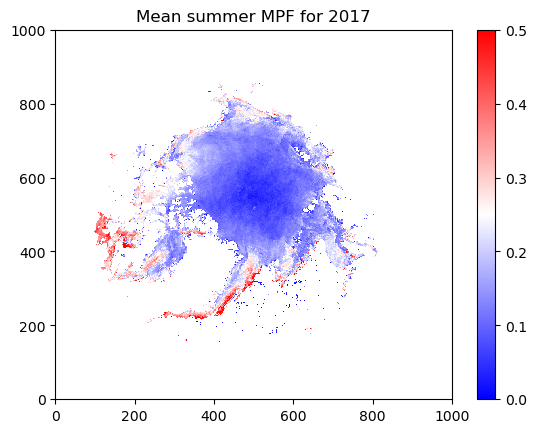

In [14]:
plt.set_cmap('bwr')
plt.pcolormesh(mean_mpf_advected, vmin=0, vmax=0.5)
plt.colorbar()
plt.title(f'Mean summer MPF for {YEAR}')

In [15]:
# mask data to keep only the points for which data are available for all three
masked_mpf, masked_lat_MISR, masked_lat_MISR = MASK_MPF_MISR(mean_mpf_advected, misr)

# calculate and plot binned data
current_year_average = calculate_binned_averages(masked_mpf, masked_misr, lat_MISR)
plot_binned_stats(current_year_average, f'Mean summer MPF as a function of lat and sigma for {YEAR}')

AttributeError: The number of `values` elements must match the length of each `sample` dimension.

### Run for all available years

Processing 2010...
Loaded MISR data


/tmp/ipykernel_105250/1301889989.py:13: RuntimeWarning: Mean of empty slice
  mean_mpf_advected = np.nanmean(subset_mpf, axis=0).reshape(1000,1000)


Loaded and processed MPF data


/tmp/ipykernel_105250/3788482062.py:61: RuntimeWarning: Mean of empty slice
  return np.nanmean(x)
/tmp/ipykernel_105250/3788482062.py:102: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


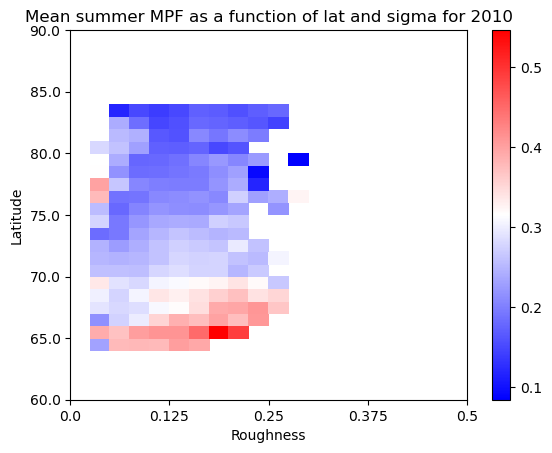

Processing 2011...
Loaded MISR data


/tmp/ipykernel_105250/1301889989.py:13: RuntimeWarning: Mean of empty slice
  mean_mpf_advected = np.nanmean(subset_mpf, axis=0).reshape(1000,1000)


Loaded and processed MPF data


/tmp/ipykernel_105250/3788482062.py:61: RuntimeWarning: Mean of empty slice
  return np.nanmean(x)
/tmp/ipykernel_105250/3788482062.py:102: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


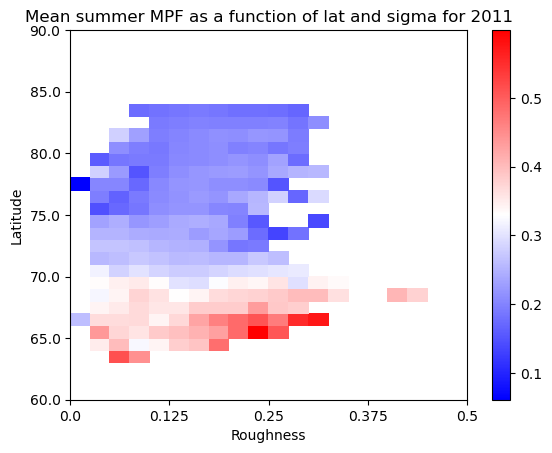

Processing 2017...
Loaded MISR data


/tmp/ipykernel_105250/1301889989.py:13: RuntimeWarning: Mean of empty slice
  mean_mpf_advected = np.nanmean(subset_mpf, axis=0).reshape(1000,1000)


Loaded and processed MPF data


/tmp/ipykernel_105250/3788482062.py:61: RuntimeWarning: Mean of empty slice
  return np.nanmean(x)
/tmp/ipykernel_105250/3788482062.py:102: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


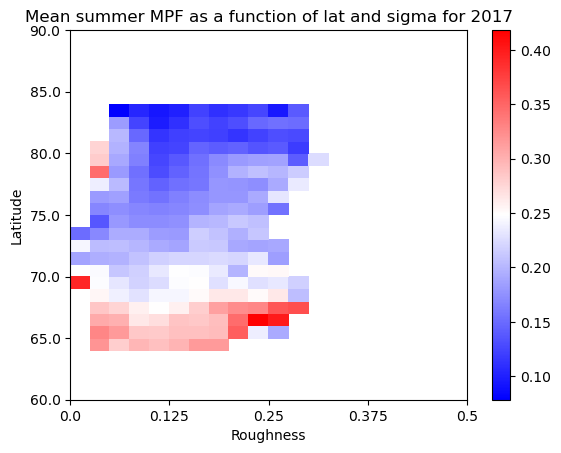

Processing 2018...
Loaded MISR data


/tmp/ipykernel_105250/1301889989.py:13: RuntimeWarning: Mean of empty slice
  mean_mpf_advected = np.nanmean(subset_mpf, axis=0).reshape(1000,1000)


Loaded and processed MPF data


/tmp/ipykernel_105250/3788482062.py:61: RuntimeWarning: Mean of empty slice
  return np.nanmean(x)
/tmp/ipykernel_105250/3788482062.py:102: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


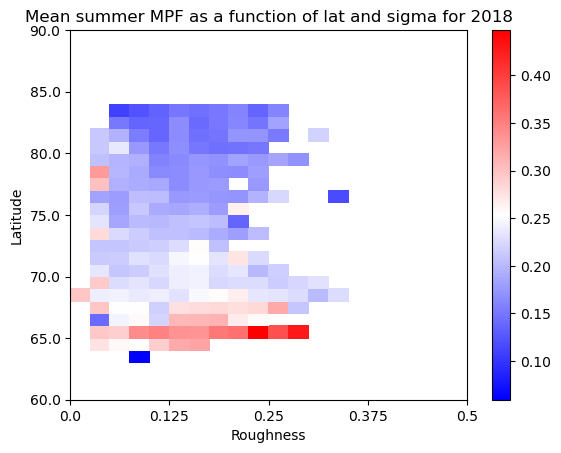

Processing 2019...
Loaded MISR data


/tmp/ipykernel_105250/1301889989.py:13: RuntimeWarning: Mean of empty slice
  mean_mpf_advected = np.nanmean(subset_mpf, axis=0).reshape(1000,1000)


Loaded and processed MPF data


/tmp/ipykernel_105250/3788482062.py:61: RuntimeWarning: Mean of empty slice
  return np.nanmean(x)
/tmp/ipykernel_105250/3788482062.py:102: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


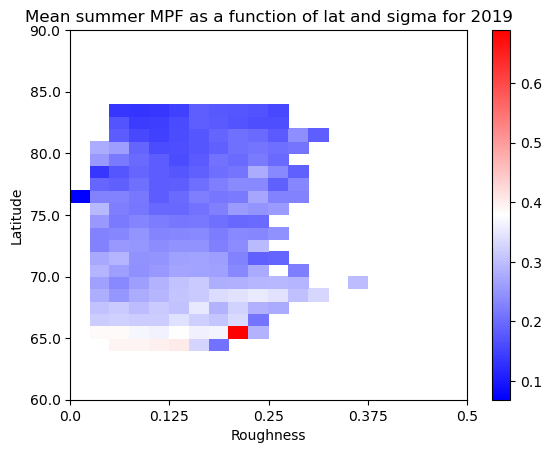

Processing 2020...
Loaded MISR data


/tmp/ipykernel_105250/1301889989.py:13: RuntimeWarning: Mean of empty slice
  mean_mpf_advected = np.nanmean(subset_mpf, axis=0).reshape(1000,1000)


Loaded and processed MPF data


/tmp/ipykernel_105250/3788482062.py:61: RuntimeWarning: Mean of empty slice
  return np.nanmean(x)
/tmp/ipykernel_105250/3788482062.py:102: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


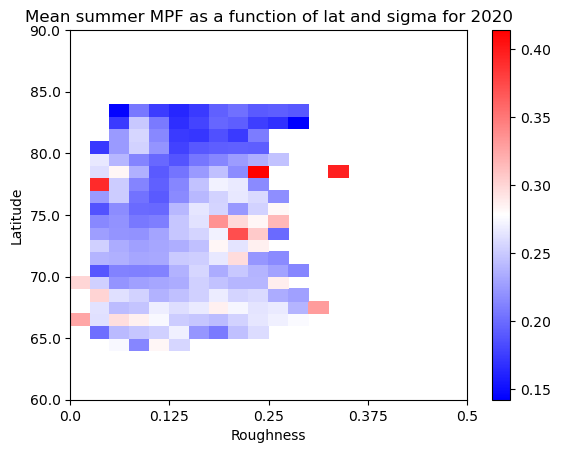

In [40]:
YEARS = [2010, 2011, 2017, 2018, 2019, 2020]

yearly_averages = np.zeros((len(YEARS), 30, 20)) # setting up array with 0s
for i in range(len(YEARS)):
    year = YEARS[i]
    print(f'Processing {year}...')
    MISR = LOAD_MISR_H5(f'/home/ssureen/MISR_data_monthly/April {year} Roughness.h5')[::8,::8]
    print(f'Loaded MISR data')

    # load, subset and find mean of mpf data
    mpf_advected = pd.read_pickle(f'/home/htweedie/melt_ponds/data/forwarded_mpfs/mpf_from_{year}0401_183 days_spacing_8.pkl')
    subset_mpf = mpf_advected.loc[format_date(year, '05', '01') : format_date(year, '08', '31')]
    mean_mpf_advected = np.nanmean(subset_mpf, axis=0).reshape(1000,1000)
    print(f'Loaded and processed MPF data')

    # mask data to keep only the points for which data are available for all three
    masked_MPF_MISRGRID, masked_MISR, masked_lat_MISR = MASK_MPF_MISR(mean_mpf_advected, MISR)

    # calculate and plot binned data
    current_year_average = calculate_binned_averages(masked_MPF_MISRGRID, masked_MISR, masked_lat_MISR)
    plot_binned_stats(current_year_average, f'Mean summer MPF as a function of lat and sigma for {year}')

    yearly_averages[i] = current_year_average


Processing 2010...
Loaded MISR data


/tmp/ipykernel_105250/2915201686.py:19: RuntimeWarning: Mean of empty slice
  mean_mpf_advected = np.nanmean(subset_mpf, axis=0).reshape(1000,1000)


Loaded and processed MPF data


/tmp/ipykernel_105250/3788482062.py:61: RuntimeWarning: Mean of empty slice
  return np.nanmean(x)
/tmp/ipykernel_105250/2915201686.py:36: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


Processing 2011...
Loaded MISR data


/tmp/ipykernel_105250/2915201686.py:19: RuntimeWarning: Mean of empty slice
  mean_mpf_advected = np.nanmean(subset_mpf, axis=0).reshape(1000,1000)


Loaded and processed MPF data


/tmp/ipykernel_105250/3788482062.py:61: RuntimeWarning: Mean of empty slice
  return np.nanmean(x)
/tmp/ipykernel_105250/2915201686.py:36: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


Processing 2017...
Loaded MISR data


/tmp/ipykernel_105250/2915201686.py:19: RuntimeWarning: Mean of empty slice
  mean_mpf_advected = np.nanmean(subset_mpf, axis=0).reshape(1000,1000)


Loaded and processed MPF data


/tmp/ipykernel_105250/3788482062.py:61: RuntimeWarning: Mean of empty slice
  return np.nanmean(x)
/tmp/ipykernel_105250/2915201686.py:36: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


Processing 2018...
Loaded MISR data


/tmp/ipykernel_105250/2915201686.py:19: RuntimeWarning: Mean of empty slice
  mean_mpf_advected = np.nanmean(subset_mpf, axis=0).reshape(1000,1000)


Loaded and processed MPF data


/tmp/ipykernel_105250/3788482062.py:61: RuntimeWarning: Mean of empty slice
  return np.nanmean(x)
/tmp/ipykernel_105250/2915201686.py:36: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


Processing 2019...
Loaded MISR data


/tmp/ipykernel_105250/2915201686.py:19: RuntimeWarning: Mean of empty slice
  mean_mpf_advected = np.nanmean(subset_mpf, axis=0).reshape(1000,1000)


Loaded and processed MPF data


/tmp/ipykernel_105250/3788482062.py:61: RuntimeWarning: Mean of empty slice
  return np.nanmean(x)
/tmp/ipykernel_105250/2915201686.py:36: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


Processing 2020...
Loaded MISR data


/tmp/ipykernel_105250/2915201686.py:19: RuntimeWarning: Mean of empty slice
  mean_mpf_advected = np.nanmean(subset_mpf, axis=0).reshape(1000,1000)


Loaded and processed MPF data


/tmp/ipykernel_105250/3788482062.py:61: RuntimeWarning: Mean of empty slice
  return np.nanmean(x)
/tmp/ipykernel_105250/2915201686.py:36: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


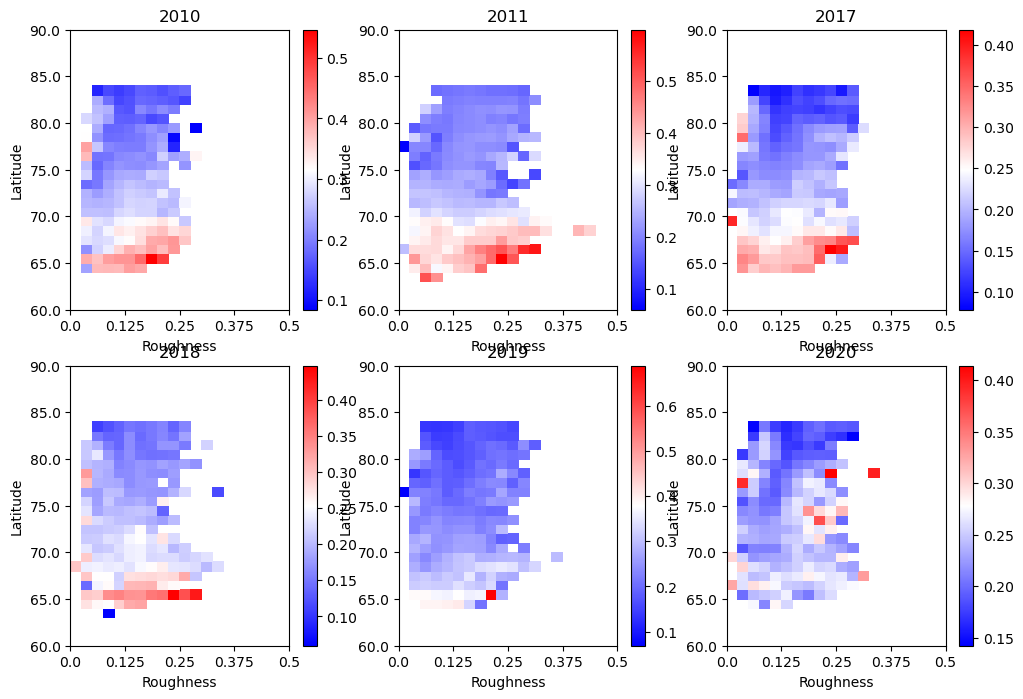

In [60]:
YEARS = [2010, 2011, 2017, 2018, 2019, 2020]
y_tick_positions = np.linspace(0, 30, 7) 
x_tick_positions = np.linspace(0, 20, 5)
y_tick_labels = np.linspace(60, 90, 7) 
x_tick_labels = np.linspace(0, 0.5, 5)

fig = plt.figure(figsize=(12,8))

yearly_averages = np.zeros((len(YEARS), 30, 20)) # setting up array with 0s
for i in range(len(YEARS)):
    year = YEARS[i]
    print(f'Processing {year}...')
    MISR = LOAD_MISR_H5(f'/home/ssureen/MISR_data_monthly/April {year} Roughness.h5')[::8,::8]
    print(f'Loaded MISR data')

    # load, subset and find mean of mpf data
    mpf_advected = pd.read_pickle(f'/home/htweedie/melt_ponds/data/forwarded_mpfs/mpf_from_{year}0401_183 days_spacing_8.pkl')
    subset_mpf = mpf_advected.loc[format_date(year, '05', '01') : format_date(year, '08', '31')]
    mean_mpf_advected = np.nanmean(subset_mpf, axis=0).reshape(1000,1000)
    print(f'Loaded and processed MPF data')

    # mask data to keep only the points for which data are available for all three
    masked_MPF_MISRGRID, masked_MISR, masked_lat_MISR = MASK_MPF_MISR(mean_mpf_advected, MISR)

    # calculate and plot binned data
    current_year_average = calculate_binned_averages(masked_MPF_MISRGRID, masked_MISR, masked_lat_MISR)

    plt.subplot(2,3,i+1)
    plt.xticks(x_tick_positions, x_tick_labels) # Relabel ticks
    plt.yticks(y_tick_positions, y_tick_labels)

    plt.ylabel("Latitude")
    plt.xlabel("Roughness")

    plt.pcolor(current_year_average)
    plt.colorbar()
    plt.title(f'{year}')

    yearly_averages[i] = current_year_average


plt.show()


/tmp/ipykernel_105250/439269978.py:8: RuntimeWarning: Mean of empty slice
  total_average[i][j] = np.nanmean(yearly_averages[:,i,j])
/tmp/ipykernel_105250/3788482062.py:102: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


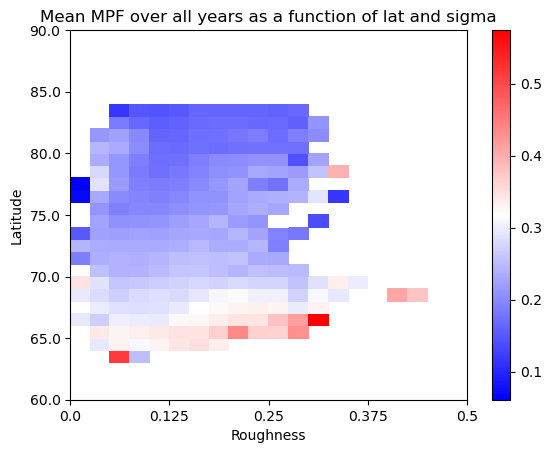

In [61]:
total_average = np.zeros((30, 20))

rows = 30
cols = 20

for i in range(rows):
    for j in range(cols):
        total_average[i][j] = np.nanmean(yearly_averages[:,i,j])

plot_binned_stats(total_average, 'Mean MPF over all years as a function of lat and sigma')


### Predicting MPF

In [63]:
YEAR = 2020

misr_path = f'/home/ssureen/MISR_data_monthly/April {YEAR} Roughness.h5'

# Load data for MISR and MPF
MISR = LOAD_MISR_H5(misr_path)[::8,::8]

# Create empty array with 0s
predicted_mpf = np.zeros((1000*1000))

# Define the bin edges latitude
lat_edges = np.linspace(60, 90, num=31)  # 30 bins latitude

# List of values
lats = lat_MISR.ravel()

# Use digitize to get the bin indices
lat_indices = np.digitize(lats, lat_edges)

# Replace out-of-range indices with nan
lat_indices = np.where((lat_indices == 0) | (lat_indices == len(lat_edges)), np.nan, lat_indices)


# Define the bin edges roughness
rough_edges = np.linspace(0, 0.5, num=20)  # 20 bins roughness

# List of values
values = MISR.ravel()

# Use digitize to get the bin indices
rough_indices = np.digitize(values, rough_edges)

# # Replace out-of-range indices with nan
rough_indices = np.where((rough_indices == 0) | (rough_indices == len(rough_edges)), np.nan, rough_indices)



In [65]:
# for each position in 8000x8000 flattened array look at latitude and roughness ... then use collated data to predict an average for that point

for i in range((1000*1000)):
    current_rough_index = rough_indices[i]
    current_lat_index = lat_indices[i]
    if not (np.isnan(current_rough_index) or np.isnan(current_lat_index)):
        predicted_mpf[i] = total_average[current_lat_index.astype(int)][current_rough_index.astype(int)]
    else:
        predicted_mpf[i] = np.nan

# We have created a faux mpf dataset for the specified year. 
# Data will be missing where data is missing in the roughness 


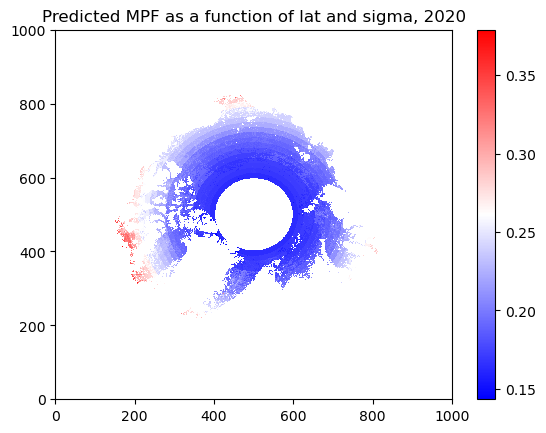

In [76]:
plt.pcolormesh(predicted_mpf.reshape(1000,1000))
plt.title(f'Predicted MPF as a function of lat and sigma, {YEAR}')
plt.colorbar()


In [70]:
rough_indices.reshape(1000,1000)
lat_indices.reshape(1000,1000)
predicted_mpf.reshape(1000,1000)
MISR.reshape(1000,1000)


array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)

/tmp/ipykernel_105250/3788482062.py:61: RuntimeWarning: Mean of empty slice
  return np.nanmean(x)
/tmp/ipykernel_105250/3788482062.py:102: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


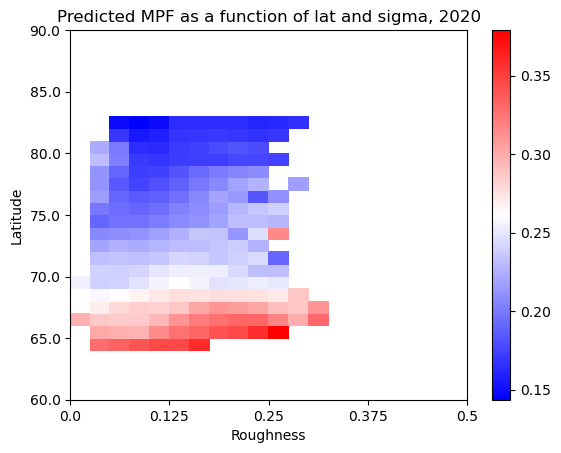

In [77]:
masked_MPF_MISRGRID, masked_MISR, masked_lat_MISR = MASK_MPF_MISR(predicted_mpf, MISR.flatten())

current_year_average = calculate_binned_averages(masked_MPF_MISRGRID, masked_MISR, masked_lat_MISR)

plot_binned_stats(current_year_average, f'Predicted MPF as a function of lat and sigma, {YEAR}')

/tmp/ipykernel_105250/3788482062.py:124: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


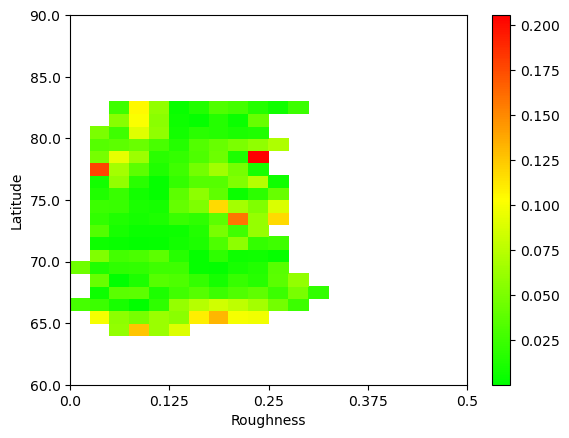

In [74]:
accuracy = np.abs(yearly_averages[-1,:,:]-current_year_average)

# Create a custom colormap that goes from green to yellow to red
colors = [(0, 1, 0), (1, 1, 0), (1, 0, 0)]  # Green, Yellow, Red
n_bins = 200  # Number of bins in the colormap
cmap_name = 'green_to_red'
custom_cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

plot_binned_accuracy(accuracy, custom_cmap)

### Calculating Accuracy for Last 3 Years

In [80]:
# SAME FOR ALL FILES

# Define the bin edges latitude
lat_edges = np.linspace(60, 90, num=31)  # 30 bins latitude

# List of values
values = lat_MISR.ravel()

# Use digitize to get the bin indices
lat_indices = np.digitize(values, lat_edges)

# Replace out-of-range indices with nan
lat_indices = np.where((lat_indices == 0) | (lat_indices == len(lat_edges)), np.nan, lat_indices)

In [81]:
def predict_mpf(misr_path, total_average_with_exclusion):
    global current_MISR
    current_MISR = LOAD_MISR_H5(misr_path)

    # Create empty array with 0s
    predicted_mpf = np.zeros((1000*1000))

    # Define the bin edges roughness
    rough_edges = np.linspace(0, 0.5, num=20)  # 20 bins roughness

    # List of values
    values = current_MISR.ravel()

    # Use digitize to get the bin indices
    rough_indices = np.digitize(values, rough_edges)

    # # Replace out-of-range indices with nan
    rough_indices = np.where((rough_indices == 0) | (rough_indices == len(rough_edges)), np.nan, rough_indices)

    for i in range(1000*1000):
        current_rough_index = rough_indices[i]
        current_lat_index = lat_indices[i]
        if not (np.isnan(current_rough_index) or np.isnan(current_lat_index)):
            predicted_mpf[i] = total_average_with_exclusion[current_lat_index.astype(int)][current_rough_index.astype(int)]
        else:
            predicted_mpf[i] = np.nan

    return predicted_mpf


In [93]:
yearly_averages[1]

array([[       nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan],
       [       nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan],
       [       nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan],
       [       nan,        nan, 0.51406576, 0.44722126,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,  

/tmp/ipykernel_105250/3045364237.py:15: RuntimeWarning: Mean of empty slice
  total_average_with_exclusion[j][k] = np.nanmean(yearly_averages_with_exclusion[:,j,k])
/tmp/ipykernel_105250/3788482062.py:61: RuntimeWarning: Mean of empty slice
  return np.nanmean(x)
/tmp/ipykernel_105250/3788482062.py:102: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


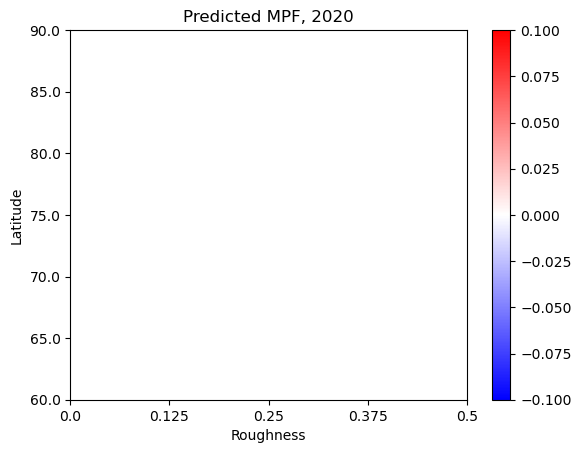

/tmp/ipykernel_105250/3788482062.py:102: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


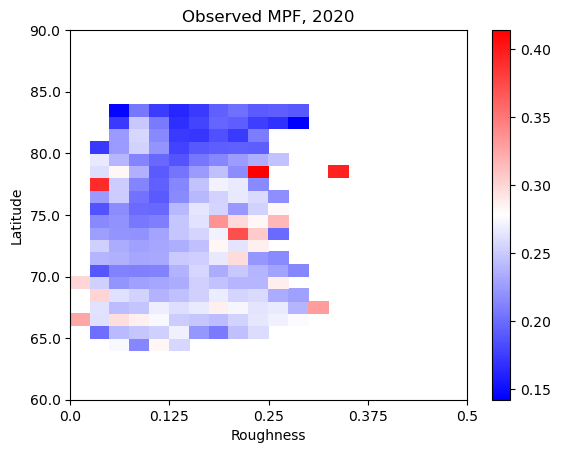

/tmp/ipykernel_105250/3788482062.py:124: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


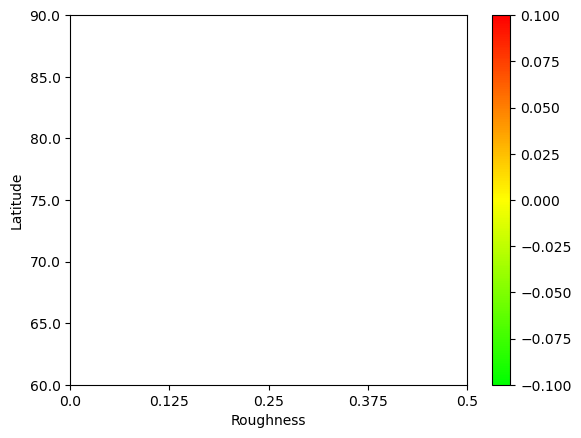

In [89]:
rows = 30
cols = 20

YEAR = 2020

total_average_with_exclusion = np.zeros((30, 20))

yearly_averages_with_exclusion = yearly_averages[0:5]
observed_average = yearly_averages[5]

current_misr_path = f'/home/ssureen/MISR_data_monthly/April {YEAR} Roughness.h5'

for j in range(rows):
    for k in range(cols):
        total_average_with_exclusion[j][k] = np.nanmean(yearly_averages_with_exclusion[:,j,k])

predicted_mpf = predict_mpf(current_misr_path, total_average_with_exclusion) # predicts raw mpf array

masked_MPF_MISRGRID, masked_MISR, masked_lat_MISR = MASK_MPF_MISR(predicted_mpf, current_MISR[::8,::8].flatten())
current_predicted_average = calculate_binned_averages(masked_MPF_MISRGRID, masked_MISR, masked_lat_MISR)

plot_binned_stats(current_predicted_average, f'Predicted MPF, {YEAR}')

plot_binned_stats(observed_average, f'Observed MPF, {YEAR}')

accuracy = current_predicted_average-observed_average
relative_accuracy = np.abs((accuracy/observed_average))
plot_binned_accuracy(relative_accuracy, custom_cmap)
    

In [88]:
np.shape(current_MISR)

(8000, 8000)

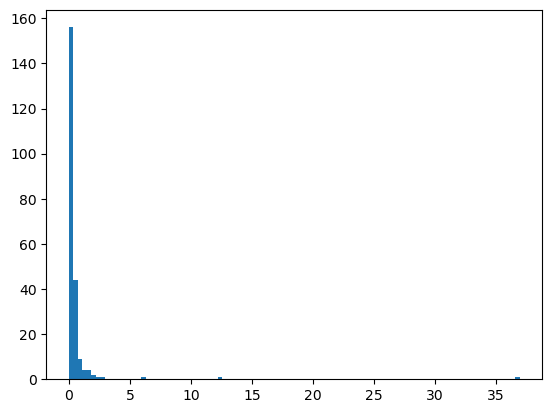

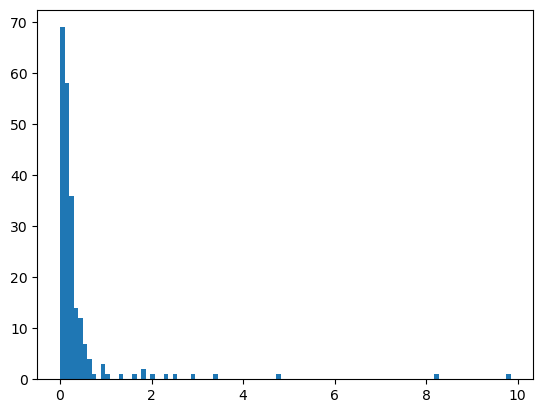

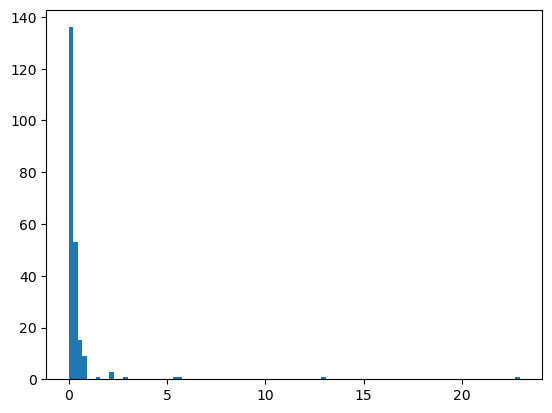

In [32]:
for i in range(0,3):
    plt.hist(relative_accuracy_scores[i].flatten(), bins = 100)
    plt.show()

[0.23760348944697013, 0.2718342157794257, 0.2157304888935049, 0.18411598751816502, 0.18639225034516008, 0.2128970231216964, 0.2408604883630756, 0.29820895938820846, 0.3326675265181414, 0.3471519768640023, 0.30830332676248207, 0.23435597850471956, 0.3282734813982104, 0.2687940891979031, 0.23396454047627693, nan, nan, nan, nan, nan]


/tmp/ipykernel_49261/4019258049.py:7: RuntimeWarning: Mean of empty slice
  mpf_slice.append(np.nanmean(yearly_averages_loaded[(-year-1),0:12,col_index]))


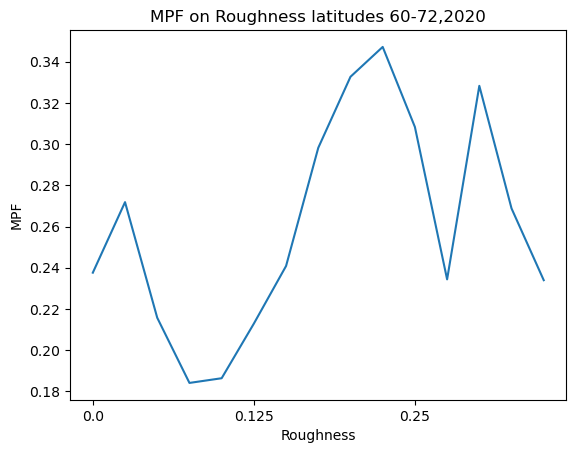

[0.37346073965335164, 0.21837493343909384, 0.3114471166543028, 0.29057094221326835, 0.2561388243607954, 0.2451000016996322, 0.24542472431916929, 0.2480520070577093, 0.2871400867718607, 0.2339252053836526, 0.23342245028256917, 0.16907695320466284, 0.24024571452186785, 0.278122773881039, 0.16318648606702907, nan, nan, nan, nan, nan]


/tmp/ipykernel_49261/4019258049.py:7: RuntimeWarning: Mean of empty slice
  mpf_slice.append(np.nanmean(yearly_averages_loaded[(-year-1),0:12,col_index]))


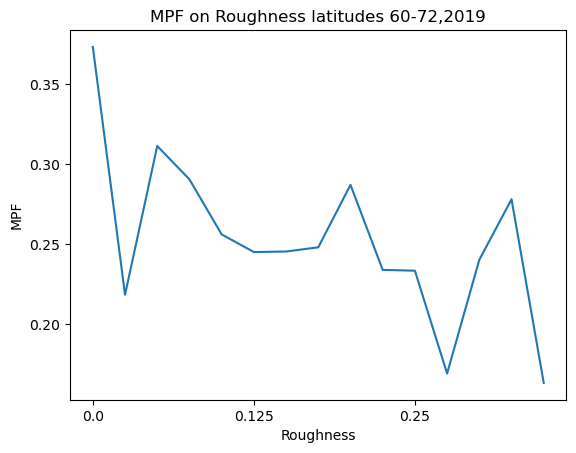

/tmp/ipykernel_49261/4019258049.py:7: RuntimeWarning: Mean of empty slice
  mpf_slice.append(np.nanmean(yearly_averages_loaded[(-year-1),0:12,col_index]))


[0.14577789106977312, 0.3335486912308568, 0.3102940224937833, 0.3206297985514445, 0.34726376493971706, 0.3466535356850358, 0.32226764660136037, 0.30752980252036877, 0.29134531736466424, 0.2360103743890385, 0.2058731499371098, 0.20991850896543948, 0.14181897244755942, nan, nan, nan, nan, nan, nan, nan]


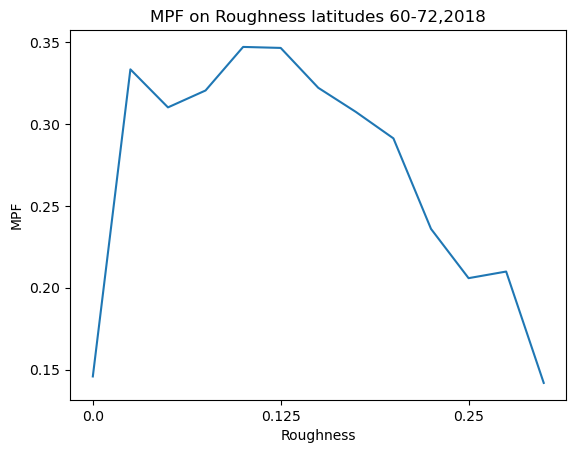

/tmp/ipykernel_49261/4019258049.py:7: RuntimeWarning: Mean of empty slice
  mpf_slice.append(np.nanmean(yearly_averages_loaded[(-year-1),0:12,col_index]))


[0.5221407432699088, 0.2256109373410597, 0.22983661587470106, 0.2595418523461592, 0.2521908866889989, 0.2677073825074691, 0.2677779350693366, 0.2490018660948051, 0.23866344410682783, 0.2623903692334329, 0.2752653525336748, 0.29686490724083886, 0.3636489615405022, 0.40239907416688786, 0.47304023957596375, 0.2524982173462969, 0.4751962477759563, nan, nan, nan]


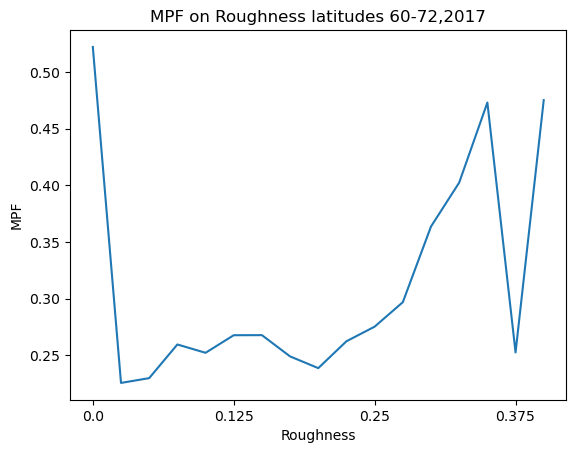

In [33]:
for year in range(0,4):

    real_year = 2020-year

    mpf_slice = []
    for col_index in range(0,20):
        mpf_slice.append(np.nanmean(yearly_averages_loaded[(-year-1),0:12,col_index]))
    print(mpf_slice)
    x_tick_positions = np.linspace(0, 20, 5)
    x_tick_labels = np.linspace(0, 0.5, 5)
    plt.xticks(x_tick_positions, x_tick_labels)
    plt.xlabel('Roughness')
    plt.ylabel('MPF')
    plt.title('MPF on Roughness latitudes 60-72,'+str(real_year))
    plt.plot(mpf_slice)
    plt.show()
    


/tmp/ipykernel_49261/1860741435.py:3: RuntimeWarning: Mean of empty slice
  mpf_slice.append(np.nanmean(yearly_averages_loaded[-1,0:12,col_index]))


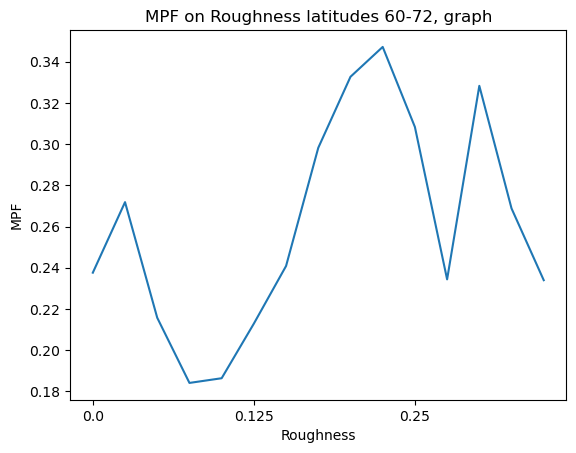

In [34]:

mpf_slice = []
for col_index in range(0,20):
    mpf_slice.append(np.nanmean(yearly_averages_loaded[-1,0:12,col_index]))

x_tick_positions = np.linspace(0, 20, 5)
x_tick_labels = np.linspace(0, 0.5, 5)
plt.xticks(x_tick_positions, x_tick_labels)
plt.xlabel('Roughness')
plt.ylabel('MPF')
plt.title('MPF on Roughness latitudes 60-72, graph')
plt.plot(mpf_slice)
plt.show()
    


In [35]:
mpf_average_slice

NameError: name 'mpf_average_slice' is not defined

In [102]:
year = 2018
mpf_advected = pd.read_pickle(f'/home/htweedie/melt_ponds/data/forwarded_mpfs/mpf_from_{year}0401_183 days_spacing_8.pkl')

fn = f'/home/ssureen/MISR_data_monthly/April {year} Roughness.h5'
MISR = LOAD_MISR_H5(fn)[::8,::8]

lon_MISR, lat_MISR, x_MISR, y_MISR = MISR_COORDS(fn)

In [95]:
mpf_advected.shape

(184, 1000000)

In [ ]:
subset_mpf = mpf_advected.loc[format_date(year, '05', '01') : format_date(year, '08', '31')]
mean_mpf_advected = np.nanmean(subset_mpf, axis=0).reshape(1000,1000)

In [101]:
MISR.shape

(1000, 1000)

In [ ]:
condition1_lat_indices = lat_MISR[lat_MISR>65 and lat_MISR<68]
condition1_MISR_indices = MISR[MISR>0.2]

mean_mpf_advected[:,condition].shape